In [8]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython
from sklearn.linear_model import LogisticRegression
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader, TensorDataset
from torch import sigmoid as sig
from delphi import train
from delphi import oracle
from delphi.utils.helpers import logistic
import delphi.utils.constants as consts
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.cuda.FloatTensor)
    print("cuda tensors...")

cuda tensors...


# Helpers

In [2]:
EXP_NAME = 'NewTruncatedBCE'
STORE_PATH = '/home/gridsan/stefanou/LogisticRegression/' + EXP_NAME
STORE_TABLE_NAME = 'TruncLogReg'

# Gradient

In [19]:
class TruncatedBCE_(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.BCEWithLogitsLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # logistic distribution
        base_distribution = Uniform(0, 1)
        transforms_ = [SigmoidTransform().inv]
        logistic = TransformedDistribution(base_distribution, transforms_)
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)
        rand_noise = logistic.sample(stacked.size())
        # add noise
        noised = stacked + rand_noise
        noised_labs = noised > 0
        filtered = args.phi(noised)
        # filter
        mask = (noised_labs).eq(targ) * filtered
        avg = 2 * (((sig(rand_noise) * mask).sum(0) / (mask.sum(0) + 1e-5)) - (sig(rand_noise)*filtered).sum(0) / (filtered.sum(0) + 1e-5))
        return -avg, None
    
trunc_bce_ = TruncatedBCE_.apply
from torch.nn import BCEWithLogitsLoss; bce_logit = BCEWithLogitsLoss()

## Default Experiment Parameters

In [20]:
# procedure hyperparameters
args = Parameters({ 
    'steps': 1000,
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'samples': 10000,
    'in_features': 2,
    'lower': -1, 
    'upper': 1,
    'samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.COSINE,
    'var': True,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'trials': 1,
    'train_split': .8,
    
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
args

using cuda...


{
  "steps": 1000,
  "workers": 0,
  "batch_size": 100,
  "bias": true,
  "num_samples": 100,
  "samples": 1000,
  "in_features": 2,
  "lower": -1,
  "upper": 1,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.1,
  "shuffle": false,
  "tol": 0.01,
  "eps": 1e-05,
  "score": true,
  "custom_lr_multiplier": "cosine",
  "var": true,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "trials": 1,
  "train_split": 0.8,
  "device": "cuda"
}

# LogisticBCE vs BCEWithLogits

In [21]:
# perform each experiment a total of 10 times
for iter_ in range(args.trials): 
    # create store
    store = Store(STORE_PATH)

    store.add_table(STORE_TABLE_NAME, { 
        'trunc_bce_cos': float,
        'mle_cos': float,
        'alpha': float, 
        'C': float,
    })
    
    # generate random uniform weights        
    ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
    ground_truth.weight = ch.nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1, args.in_features])))
    if ground_truth.bias is not None: 
        ground_truth.bias = ch.nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

    # generate data
    X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
    z = ground_truth(X) + logistic.sample(ch.Size([args.samples, 1])).cuda()
    y = ch.where(z > 0, ch.ones(1), ch.zeros(1))
    
    # create store
    for C in [-2, -1.75, -1.5, -1.25, -1, -.75, -.5, -.25]:
        # create new trunaction mechanism
        args.__setattr__('phi', oracle.Left(Tensor([C])))
        
        # truncate
        indices = args.phi(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]
        args.__setattr__('alpha', Tensor([y_trunc.size(0) / args.samples]))

        # split data into train and validation sets
        ds = TensorDataset(X, y)
        train_count = int(args.train_split*len(ds))
        val_count = len(ds) - train_count
        loaders = ch.utils.data.random_split(ds, (train_count, val_count))

        # run trunc bce
        args.__setattr__('custom_criterion', trunc_bce_)
        # optimize logistic bce gradient
        trunc_model = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
        trunc_model = train.train_model(args, trunc_model, loaders, store=store)
        
        # naive estimates 
        naive_log_reg = LogisticRegression(penalty='none')
        naive_log_reg.fit(x_trunc.cpu(), y_trunc.cpu().flatten())

        # parameter estimates 
        real_params = ch.cat([ground_truth.weight, ground_truth.bias.unsqueeze(0)], axis=1)
        mle_params = ch.cat([Tensor(naive_log_reg.coef_), Tensor(naive_log_reg.intercept_).unsqueeze(0)], axis=1)
        trunc_bce_params = ch.cat([trunc_model.weight, trunc_model.bias.unsqueeze(0)], axis=1)
        
        store[STORE_TABLE_NAME].append_row({ 
            'trunc_bce_cos': ch.nn.functional.cosine_similarity(trunc_bce_params.cuda(), real_params),
            'mle_cos': ch.nn.functional.cosine_similarity(mle_params, real_params),
            'alpha': float(args.alpha),
            'C': C,
        })

        IPython.display.clear_output(wait=False)

    # close current store
    store.close()

  0%|          | 0/800 [00:00<?, ?it/s]

avg: tensor([[0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0713],
        [0.0713],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0000],
        [0.0000],
        [0.0713],
        [0.0713],
        [0.0713],
        [0.0000],
        [0.0713],
     

avg: tensor([[-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
        [-1.1056],
       

avg: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
 

avg: tensor([[-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
        [-1.0629],
       

KeyboardInterrupt: 

# Results

In [17]:
reader = CollectionReader(STORE_PATH)

results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 86.56it/s]


,trunc_bce_cos,mle_cos,alpha,C,exp_id
0,-0.288418,0.935133,0.721,-2.00,cc367716-f867-44f7-9304-7cd5b712f6d5
1,-0.155660,0.899049,0.695,-1.75,cc367716-f867-44f7-9304-7cd5b712f6d5
2,-0.439240,0.866154,0.676,-1.50,cc367716-f867-44f7-9304-7cd5b712f6d5
3,-0.085930,0.815589,0.654,-1.25,cc367716-f867-44f7-9304-7cd5b712f6d5
4,0.072751,0.771972,0.635,-1.00,cc367716-f867-44f7-9304-7cd5b712f6d5


# All Trials

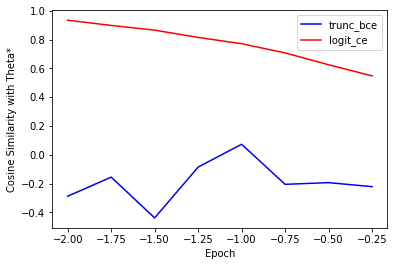

In [18]:
# variance vs param mse
sns.lineplot(data=results, x='C', y='trunc_bce_cos', label='trunc_bce', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='logit_ce', color='red')
ax.set(xlabel='Epoch', ylabel='Cosine Similarity with Theta*')
plt.show()

In [66]:
len(results)

80

In [7]:
filtered = Tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

stuff = Tensor([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]]).eq(Tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0]))[...,None]

stuff * filtered

tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [8]:
stuff

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True],
         [ True]]])

In [12]:
1 - ch.exp(-Tensor([-0.2534]))

tensor([-0.2884])

In [36]:
from torch.nn import BCEWithLogitsLoss




In [37]:
X, z, y

(tensor([[ 54.3043, -72.1545],
         [-22.5310,   9.2756],
         [ 58.2956,  90.2150],
         [ 43.9802, -21.3367],
         [  4.7401, -65.6959],
         [ -4.1178, -16.7170],
         [-93.5648,  34.9560],
         [-58.1004,  99.4695],
         [ 37.4152,  -2.5600],
         [-55.5908,  63.1597]]),
 tensor([[  88.4926],
         [ -27.1840],
         [   7.4206],
         [  54.2123],
         [  39.9068],
         [   5.7514],
         [-102.1335],
         [-106.2591],
         [  36.8696],
         [ -83.0426]]),
 tensor([[1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]]))

Correlation between real and estimated gradient:  tensor(0.9935)


In [59]:
gt_g

tensor([[-0.1000],
        [ 0.0975],
        [ 0.0000],
        [-0.1000],
        [-0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.0122],
        [ 0.1000]])

In [60]:
log_g

tensor([[ 1.9856],
        [ 1.1565],
        [-0.8731],
        [-1.2506],
        [-0.8169],
        [-2.1066],
        [-1.1343],
        [-0.8081],
        [-1.7252],
        [-0.6086]])

In [68]:

log_loss = logistic_bce(pred, y)
log_g, = ch.autograd.grad(log_loss, [pred])

In [69]:
log_g

tensor([[ 0.0000],
        [ 0.0976],
        [ 0.0073],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0111],
        [ 0.0000]])